In [212]:
import pandas as pd
import numpy as np
import glmnet_python
import statsmodels.api as sm
from glmnet import glmnet
from scipy import optimize
import scipy as sc
import datetime
from dateutil.relativedelta import relativedelta
import math


from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import RegressorChain
from sklearn.multioutput import ClassifierChain

import sklearn.metrics as metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score 
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt #for plots
%matplotlib inline

from datetime import datetime
from dateutil.parser import parse

In [2]:
#Get data
df_q = pd.read_csv('df_q.csv', index_col = 'Date')
#I need the index to be a datetime object
df_q.index = pd.to_datetime(df_q.index)

In [3]:
#Genertating a list containing only the quaterly input variables
predictors_q = list(df_q.columns)
predictors_q = predictors_q[1:]

# Normalize predictors
df_q[predictors_q] = MinMaxScaler().fit_transform(df_q[predictors_q])
df_q.describe()

,GDPC1,GDPC1_lag1,GDPC1_lag2,GS10,TB3MS,GS1,AAA10YM,DTB6,BAA10YM,FEDFUNDS,...,R_M2NS,R_Unfilled Orders,R_W875RX1,R_MABMM301USM189S,R_S&P500,R_S&P500_change,USREC_lag6,mad_10Y-3M,mad_10Y-1Y,mad_S&P500
count,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,...,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000
mean,0.735912,0.497899,0.498890,0.343022,0.305044,0.308160,0.395949,0.310756,0.317061,0.282589,...,0.334818,0.591798,0.302638,0.338407,0.276217,0.669350,0.119253,0.171513,0.142364,0.117808
std,0.791027,0.133970,0.134541,0.217978,0.211082,0.208890,0.222318,0.209670,0.151923,0.207753,...,0.251743,0.137689,0.341014,0.252526,0.244524,0.154934,0.312714,0.150994,0.130407,0.143793
min,-2.211668,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.351949,0.432156,0.432156,0.185696,0.147773,0.145735,0.235621,0.150044,0.215157,0.128718,...,0.152258,0.503944,0.080441,0.156620,0.093522,0.595320,0.000000,0.088112,0.068793,0.012887
50%,0.745878,0.499652,0.500420,0.325972,0.312943,0.309661,0.366667,0.318664,0.310854,0.273155,...,0.268789,0.592570,0.118332,0.273244,0.152477,0.695908,0.000000,0.130426,0.104765,0.042232
75%,1.098551,0.560852,0.563854,0.464680,0.408300,0.423690,0.552288,0.423706,0.410244,0.378671,...,0.463242,0.678735,0.542854,0.468522,0.452786,0.762781,0.000000,0.189236,0.162233,0.195207
max,3.720482,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [147]:
y_q

,GDPC1,GDPC1+1,GDPC1+2,GDPC1+3,GDPC1+4
Date,,,,,
1962-01-01,1.752344,0.895579,1.213599,0.327783,1.079818
1962-04-01,0.895579,1.213599,0.327783,1.079818,1.109672
1962-07-01,1.213599,0.327783,1.079818,1.109672,2.151135
1962-10-01,0.327783,1.079818,1.109672,2.151135,0.651326
1963-01-01,1.079818,1.109672,2.151135,0.651326,2.064748
...,...,...,...,...,...
2018-10-01,0.270599,0.759396,0.497212,0.519070,0.524702
2019-01-01,0.759396,0.497212,0.519070,0.524702,NaN
2019-04-01,0.497212,0.519070,0.524702,NaN,NaN


In [4]:
#I need the depedent variable to have multiple horizons
q_hrz_lst = ['GDPC1']
for i in [1,2,3,4]:
    df_q['GDPC1+'+str(i)] = df_q['GDPC1'].shift(-i)
    q_hrz_lst.append('GDPC1+'+str(i))

y_q = df_q[q_hrz_lst]
x_q = df_q.drop(columns = q_hrz_lst)


In [84]:
def QPS(prediction_probability, Truth):
    '''Quadratic Probability Score calculator'''
    qps_lst = []
    for i in range(len(prediction_probability)):
        qps_lst.append(2*(prediction_probability[i] - Truth[i])**2)
    qps_sum = sum(qps_lst)
    return (qps_sum/len(prediction_probability))

def error_metrics(yprob, ypred, ytest):
    error_lst = [QPS(yprob, ytest),
                 log_loss(ytest, yprob), 
                 accuracy_score(ytest, ypred),
                 roc_auc_score(ytest,ypred),
                 confusion_matrix(ytest, ypred)[0, 1],
                 confusion_matrix(ytest, ypred)[1, 0]
                ]
    return error_lst


def regression_results(y_true, y_pred):

    # Regression metrics
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
    mse = metrics.mean_squared_error(y_true, y_pred) 
    r2 = metrics.r2_score(y_true, y_pred)

    return [mean_absolute_error, mse, math.sqrt(mse), r2]

# Model 5 - Monthly tcis with MultipleOutput 

In [22]:
#I need the index to be a datetiqe object
df_q.index = pd.to_datetime(df_q.index)

y_q_all_tcis = df_q[q_hrz_lst]
y_q_all_tcis = y_q.dropna()
x_q_all_tcis = df_q.drop(columns = q_hrz_lst)
x_q_all_tcis = x_q_all_tcis[:y_q_all_tcis.shape[0]]

n_splits = len(x_q_all_tcis)-2
#Nuqber of train/cv/test folds
#58 or 57 is the nuqber for annual splits qore or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_q_all_tcis)
for i in range(28*4):
    next(trainTestSplit)#Skip the first fold

rqse_q_all_tcis = []
loss_q_all_tcis = []
predicted_q_all_tcis = np.array([])
pred_proba_q_all_tcis = np.array([])

for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_q_all_tcis.iloc[trainCvIndices,0:], y_q_all_tcis.iloc[trainCvIndices,0:]
    XTest, yTest       = x_q_all_tcis.iloc[testIndices,0:]   , y_q_all_tcis.iloc[testIndices,0:]
    
    # Then, we build a list of the forq [ ( [...Train Indices...], [...CV Indices...]  )]
    testLength = len(XTest)
    tcis = [(list(range(trainCvIndices[0],trainCvIndices[-testLength])),
                     list(range(trainCvIndices[-testLength],trainCvIndices[-1]+1)))]
    
    #qodel construction and wrapper
    model_q_all_tcis = LassoCV(
            n_alphas = 100,
            cv = tcis,
            max_iter = 200000,
            tol = 1e-3,
            n_jobs = -1,
            fit_intercept = True,
            random_state = 1)
    wrapper = MultiOutputRegressor(model_q_all_tcis)
    wrapper.fit(XTrainCv, yTrainCv)
    
    #Probabilities and predictions
    ypredicted_q_all_tcis = wrapper.predict(XTest)
    predicted_q_all_tcis = np.append(predicted_q_all_tcis, ypredicted_q_all_tcis)

    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())

Training: 1962-01-01 -- 1989-10-01 , Cv: 1990-01-01 -- 1990-01-01 , Test: 1990-04-01 -- 1990-04-01
Training: 1962-01-01 -- 1990-01-01 , Cv: 1990-04-01 -- 1990-04-01 , Test: 1990-07-01 -- 1990-07-01
Training: 1962-01-01 -- 1990-04-01 , Cv: 1990-07-01 -- 1990-07-01 , Test: 1990-10-01 -- 1990-10-01
Training: 1962-01-01 -- 1990-07-01 , Cv: 1990-10-01 -- 1990-10-01 , Test: 1991-01-01 -- 1991-01-01
Training: 1962-01-01 -- 1990-10-01 , Cv: 1991-01-01 -- 1991-01-01 , Test: 1991-04-01 -- 1991-04-01
Training: 1962-01-01 -- 1991-01-01 , Cv: 1991-04-01 -- 1991-04-01 , Test: 1991-07-01 -- 1991-07-01
Training: 1962-01-01 -- 1991-04-01 , Cv: 1991-07-01 -- 1991-07-01 , Test: 1991-10-01 -- 1991-10-01
Training: 1962-01-01 -- 1991-07-01 , Cv: 1991-10-01 -- 1991-10-01 , Test: 1992-01-01 -- 1992-01-01
Training: 1962-01-01 -- 1991-10-01 , Cv: 1992-01-01 -- 1992-01-01 , Test: 1992-04-01 -- 1992-04-01
Training: 1962-01-01 -- 1992-01-01 , Cv: 1992-04-01 -- 1992-04-01 , Test: 1992-07-01 -- 1992-07-01
Training: 

Training: 1962-01-01 -- 2010-07-01 , Cv: 2010-10-01 -- 2010-10-01 , Test: 2011-01-01 -- 2011-01-01
Training: 1962-01-01 -- 2010-10-01 , Cv: 2011-01-01 -- 2011-01-01 , Test: 2011-04-01 -- 2011-04-01
Training: 1962-01-01 -- 2011-01-01 , Cv: 2011-04-01 -- 2011-04-01 , Test: 2011-07-01 -- 2011-07-01
Training: 1962-01-01 -- 2011-04-01 , Cv: 2011-07-01 -- 2011-07-01 , Test: 2011-10-01 -- 2011-10-01
Training: 1962-01-01 -- 2011-07-01 , Cv: 2011-10-01 -- 2011-10-01 , Test: 2012-01-01 -- 2012-01-01
Training: 1962-01-01 -- 2011-10-01 , Cv: 2012-01-01 -- 2012-01-01 , Test: 2012-04-01 -- 2012-04-01
Training: 1962-01-01 -- 2012-01-01 , Cv: 2012-04-01 -- 2012-04-01 , Test: 2012-07-01 -- 2012-07-01
Training: 1962-01-01 -- 2012-04-01 , Cv: 2012-07-01 -- 2012-07-01 , Test: 2012-10-01 -- 2012-10-01
Training: 1962-01-01 -- 2012-07-01 , Cv: 2012-10-01 -- 2012-10-01 , Test: 2013-01-01 -- 2013-01-01
Training: 1962-01-01 -- 2012-10-01 , Cv: 2013-01-01 -- 2013-01-01 , Test: 2013-04-01 -- 2013-04-01
Training: 

In [192]:
#Uncomment below when needed
#predicted_q_all_tcis = predicted_q_all_tcis.tolist()

predicted_lst_0 = predicted_q_all_tcis[0::5]
yTest_q0 = df_q['GDPC1']['1990-04-01':'2018-10-01']
errors_0 = regression_results(yTest_q0, predicted_lst_0)

predicted_lst_3 = predicted_q_all_tcis[1::5]
yTest_q3 = df_q['GDPC1+1']['1990-02-01':'2018-12-01']
errors_3 = regression_results(yTest_q3, predicted_lst_3)

predicted_lst_6 = predicted_q_all_tcis[2::5]
yTest_q6 = df_q['GDPC1+2']['1990-02-01':'2018-12-01']
errors_6 = regression_results(yTest_q6, predicted_lst_6)

predicted_lst_9 = predicted_q_all_tcis[3::5]
yTest_q9 = df_q['GDPC1+3']['1990-02-01':'2018-12-01']
errors_9 = regression_results(yTest_q9, predicted_lst_9)


predicted_lst_12 = predicted_q_all_tcis[4::5]
yTest_q12 = df_q['GDPC1+4']['1990-02-01':'2018-12-01']
errors_12 = regression_results(yTest_q12, predicted_lst_12)



errors_tcis_all = pd.DataFrame(data = [errors_0,
                                        errors_3,
                                        errors_6,
                                        errors_9,
                                        errors_12],
                                 index = ['lag_0',
                                         'lag_3',
                                         'lag_6',
                                         'lag_9',
                                         'lag_12'],
                                columns = ['MAE', 'MSE', 'RMSE', 'R^2'])

errors_tcis_all

,MAE,MSE,RMSE,R^2
lag_0,0.435990,0.372240,0.610115,-0.082010
lag_3,0.426890,0.301336,0.548941,0.123321
lag_6,0.451163,0.355218,0.596002,-0.040828
lag_9,0.430914,0.340213,0.583277,-0.060214
lag_12,0.452189,0.388188,0.623048,-0.250091


# Model 6 -  Monthly tcsv with MultipleOutput 

In [35]:
#I need the index to be a datetiqe object
df_q.index = pd.to_datetime(df_q.index)

y_q_all_tscv = df_q[q_hrz_lst]
y_q_all_tscv = y_q.dropna()
x_q_all_tscv = df_q.drop(columns = q_hrz_lst)
x_q_all_tscv = x_q_all_tscv[:y_q_all_tscv.shape[0]]

n_splits = len(x_q_all_tscv)-2
#Nuqber of train/cv/test folds
#58 or 57 is the nuqber for annual splits qore or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_q_all_tscv)
for i in range(28*4):
    next(trainTestSplit)#Skip the first fold

rqse_q_all_tscv = []
loss_q_all_tscv = []
predicted_q_all_tscv = np.array([])
pred_proba_q_all_tscv = np.array([])

for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_q_all_tscv.iloc[trainCvIndices,0:], y_q_all_tscv.iloc[trainCvIndices,0:]
    XTest, yTest       = x_q_all_tscv.iloc[testIndices,0:]   , y_q_all_tscv.iloc[testIndices,0:]
    
    # Then, we build a list of the forq [ ( [...Train Indices...], [...CV Indices...]  )]
    testLength = len(XTest)
    
    # Cross validation split
    tscv = TimeSeriesSplit(n_splits = 10).split(XTrainCv, y = yTrainCv)
#     for i in range(1): #Skip first fold because no recessions
#         next(tscv)
    
    
    #model construction and wrapper
    model_q_all_tscv = LassoCV(
            n_alphas = 100,
            cv = list(tscv),
            max_iter = 200000,
            tol = 1e-3,
            n_jobs = -1,
            fit_intercept = True,
            random_state = 1)
    wrapper = MultiOutputRegressor(model_q_all_tscv)
    wrapper.fit(XTrainCv, yTrainCv)
    
    #Probabilities and predictions
    ypredicted_q_all_tscv = wrapper.predict(XTest)
    predicted_q_all_tscv = np.append(predicted_q_all_tscv, ypredicted_q_all_tscv)

    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())

Training: 1962-01-01 -- 1989-10-01 , Cv: 1990-01-01 -- 1990-01-01 , Test: 1990-04-01 -- 1990-04-01
Training: 1962-01-01 -- 1990-01-01 , Cv: 1990-04-01 -- 1990-04-01 , Test: 1990-07-01 -- 1990-07-01
Training: 1962-01-01 -- 1990-04-01 , Cv: 1990-07-01 -- 1990-07-01 , Test: 1990-10-01 -- 1990-10-01
Training: 1962-01-01 -- 1990-07-01 , Cv: 1990-10-01 -- 1990-10-01 , Test: 1991-01-01 -- 1991-01-01
Training: 1962-01-01 -- 1990-10-01 , Cv: 1991-01-01 -- 1991-01-01 , Test: 1991-04-01 -- 1991-04-01
Training: 1962-01-01 -- 1991-01-01 , Cv: 1991-04-01 -- 1991-04-01 , Test: 1991-07-01 -- 1991-07-01
Training: 1962-01-01 -- 1991-04-01 , Cv: 1991-07-01 -- 1991-07-01 , Test: 1991-10-01 -- 1991-10-01
Training: 1962-01-01 -- 1991-07-01 , Cv: 1991-10-01 -- 1991-10-01 , Test: 1992-01-01 -- 1992-01-01
Training: 1962-01-01 -- 1991-10-01 , Cv: 1992-01-01 -- 1992-01-01 , Test: 1992-04-01 -- 1992-04-01
Training: 1962-01-01 -- 1992-01-01 , Cv: 1992-04-01 -- 1992-04-01 , Test: 1992-07-01 -- 1992-07-01
Training: 

Training: 1962-01-01 -- 2010-07-01 , Cv: 2010-10-01 -- 2010-10-01 , Test: 2011-01-01 -- 2011-01-01
Training: 1962-01-01 -- 2010-10-01 , Cv: 2011-01-01 -- 2011-01-01 , Test: 2011-04-01 -- 2011-04-01
Training: 1962-01-01 -- 2011-01-01 , Cv: 2011-04-01 -- 2011-04-01 , Test: 2011-07-01 -- 2011-07-01
Training: 1962-01-01 -- 2011-04-01 , Cv: 2011-07-01 -- 2011-07-01 , Test: 2011-10-01 -- 2011-10-01
Training: 1962-01-01 -- 2011-07-01 , Cv: 2011-10-01 -- 2011-10-01 , Test: 2012-01-01 -- 2012-01-01
Training: 1962-01-01 -- 2011-10-01 , Cv: 2012-01-01 -- 2012-01-01 , Test: 2012-04-01 -- 2012-04-01
Training: 1962-01-01 -- 2012-01-01 , Cv: 2012-04-01 -- 2012-04-01 , Test: 2012-07-01 -- 2012-07-01
Training: 1962-01-01 -- 2012-04-01 , Cv: 2012-07-01 -- 2012-07-01 , Test: 2012-10-01 -- 2012-10-01
Training: 1962-01-01 -- 2012-07-01 , Cv: 2012-10-01 -- 2012-10-01 , Test: 2013-01-01 -- 2013-01-01
Training: 1962-01-01 -- 2012-10-01 , Cv: 2013-01-01 -- 2013-01-01 , Test: 2013-04-01 -- 2013-04-01
Training: 

In [243]:
#Uncomment below when needed
#predicted_q_all_tscv = predicted_q_all_tscv.tolist()

predicted_lst_0 = predicted_q_all_tscv[0::5]
yTest_q0 = df_q['GDPC1']['1990-04-01':'2018-10-01']
errors_0 = regression_results(yTest_q0, predicted_lst_0)

predicted_lst_3 = predicted_q_all_tscv[1::5]
yTest_q3 = df_q['GDPC1+1']['1990-02-01':'2018-12-01']
errors_3 = regression_results(yTest_q3, predicted_lst_3)

predicted_lst_6 = predicted_q_all_tscv[2::5]
yTest_q6 = df_q['GDPC1+2']['1990-02-01':'2018-12-01']
errors_6 = regression_results(yTest_q6, predicted_lst_6)

predicted_lst_9 = predicted_q_all_tscv[3::5]
yTest_q9 = df_q['GDPC1+3']['1990-02-01':'2018-12-01']
errors_9 = regression_results(yTest_q9, predicted_lst_9)


predicted_lst_12 = predicted_q_all_tscv[4::5]
yTest_q12 = df_q['GDPC1+4']['1990-02-01':'2018-12-01']
errors_12 = regression_results(yTest_q12, predicted_lst_12)



errors_tscv_all = pd.DataFrame(data = [errors_0,
                                        errors_3,
                                        errors_6,
                                        errors_9,
                                        errors_12],
                                 index = ['lag_0',
                                         'lag_3',
                                         'lag_6',
                                         'lag_9',
                                         'lag_12'],
                                columns = ['MAE', 'MSE', 'RMSE', 'R^2'])

errors_tscv_all

,MAE,MSE,RMSE,R^2
lag_0,0.386625,0.251968,0.501964,0.267591
lag_3,0.406987,0.301116,0.548741,0.123961
lag_6,0.437207,0.377307,0.614253,-0.105550
lag_9,0.417459,0.344932,0.587309,-0.074921
lag_12,0.412623,0.349103,0.590849,-0.124223


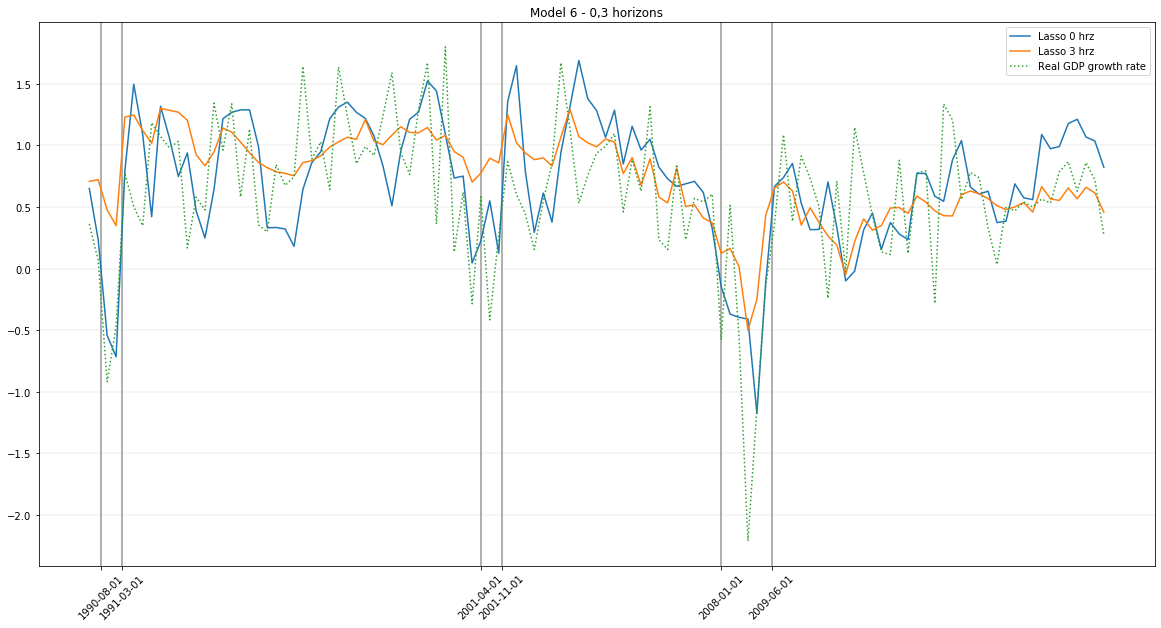

In [244]:
recession_dates = ['1990-08-01',
                '1991-03-01',
                '2001-04-01',
                '2001-11-01',
                '2008-01-01',
                '2009-06-01']
recession_dates_time = [datetime.strptime(x, '%Y-%m-%d') for x in recession_dates]


#Plotting
testdates = pd.date_range(start = "1990-02-01",
                          end = "2018-10-01",
                         freq = 'Q')

plt.figure(figsize=(20,10))
plt.plot(testdates, predicted_lst_0, label = 'Lasso 0 hrz')
plt.plot(testdates, predicted_lst_3, label = 'Lasso 3 hrz')
# plt.plot(testdates, predicted_lst_6, label = 'Lasso 6 hrz')
# plt.plot(testdates, predicted_lst_9, label = 'Lasso 9 hrz')
# plt.plot(testdates, predicted_lst_12, label = 'Lasso 12 hrz')
plt.plot(testdates, yTest_q0, label = 'Real GDP growth rate', linestyle = ':')



plt.xticks(ticks = recession_dates_time, labels = recession_dates, rotation = 45)



plt.title('Model 6 - 0,3 horizons')
plt.grid(linewidth = 2, axis = 'x')
plt.grid(linestyle = '-', linewidth = 0.25, axis = 'y')
plt.legend()
plt.savefig('Model 6 - 0,3 horizons.png')
plt.show()

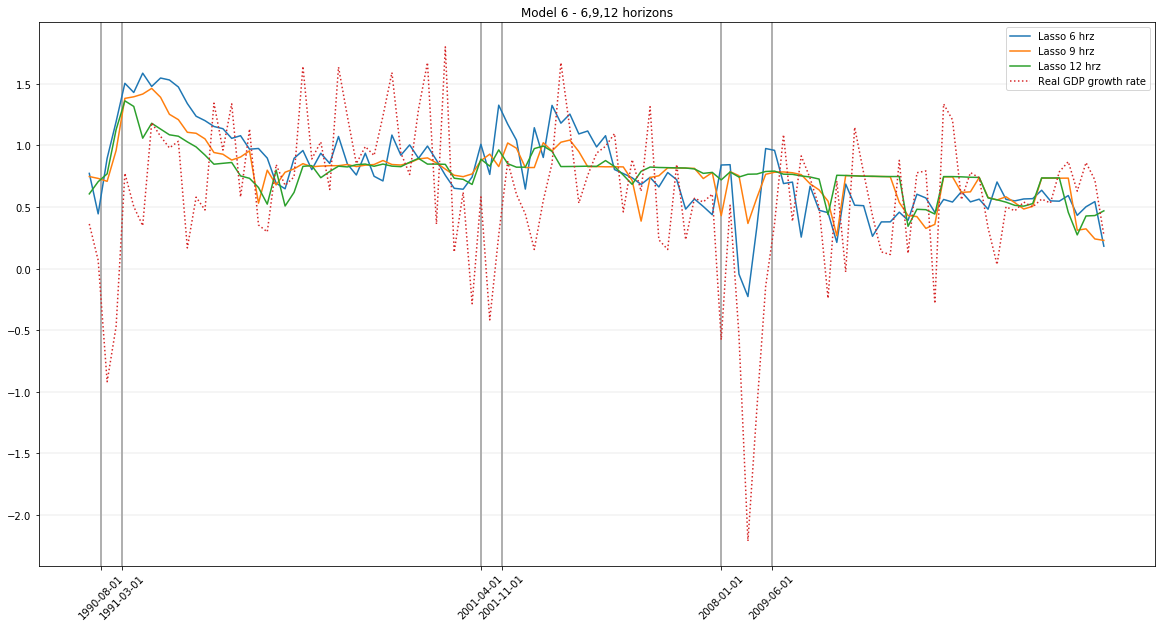

In [242]:
recession_dates = ['1990-08-01',
                '1991-03-01',
                '2001-04-01',
                '2001-11-01',
                '2008-01-01',
                '2009-06-01']
recession_dates_time = [datetime.strptime(x, '%Y-%m-%d') for x in recession_dates]


#Plotting
testdates = pd.date_range(start = "1990-02-01",
                          end = "2018-10-01",
                         freq = 'Q')

plt.figure(figsize=(20,10))
# plt.plot(testdates, predicted_lst_0, label = 'Lasso 0 hrz')
# plt.plot(testdates, predicted_lst_3, label = 'Lasso 3 hrz')
plt.plot(testdates, predicted_lst_6, label = 'Lasso 6 hrz')
plt.plot(testdates, predicted_lst_9, label = 'Lasso 9 hrz')
plt.plot(testdates, predicted_lst_12, label = 'Lasso 12 hrz')
plt.plot(testdates, yTest_q0, label = 'Real GDP growth rate', linestyle = ':')



plt.xticks(ticks = recession_dates_time, labels = recession_dates, rotation = 45)



plt.title('Model 6 - 6,9,12 horizons')
plt.grid(linewidth = 2, axis = 'x')
plt.grid(linestyle = '-', linewidth = 0.25, axis = 'y')
plt.legend()
plt.savefig('Model 6 - 6,9,12 horizons.png')
plt.show()

# Model 7 - chained tscv

In [219]:
#I need the index to be a datetiqe object
df_q.index = pd.to_datetime(df_q.index)

y_q_chain_tscv = df_q[q_hrz_lst]
y_q_chain_tscv = y_q.dropna()
x_q_chain_tscv = df_q.drop(columns = q_hrz_lst)
x_q_chain_tscv = x_q_chain_tscv[:y_q_chain_tscv.shape[0]]

n_splits = len(x_q_chain_tscv)-2
#Nuqber of train/cv/test folds
#58 or 57 is the nuqber for annual splits qore or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_q_chain_tscv)
for i in range(28*4):
    next(trainTestSplit)#Skip the first fold

rqse_q_chain_tscv = []
loss_q_chain_tscv = []
predicted_q_chain_tscv = np.array([])
pred_proba_q_chain_tscv = np.array([])

for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_q_chain_tscv.iloc[trainCvIndices,0:], y_q_chain_tscv.iloc[trainCvIndices,0:]
    XTest, yTest       = x_q_chain_tscv.iloc[testIndices,0:]   , y_q_chain_tscv.iloc[testIndices,0:]
    
    # Then, we build a list of the forq [ ( [...Train Indices...], [...CV Indices...]  )]
    testLength = len(XTest)
    
    # Cross validation split
    tscv = TimeSeriesSplit(n_splits = 10).split(XTrainCv, y = yTrainCv)
#     for i in range(1): #Skip first fold because no recessions
#         next(tscv)
    
    
    #model construction and wrapper
    model_q_chain_tscv = LassoCV(
            n_alphas = 100,
            cv = list(tscv),
            max_iter = 200000,
            tol = 1e-3,
            n_jobs = -1,
            fit_intercept = True,
            random_state = 1)
    wrapper = RegressorChain(model_q_chain_tscv)
    wrapper.fit(XTrainCv, yTrainCv)
    
    #Probabilities and predictions
    ypredicted_q_chain_tscv = wrapper.predict(XTest)
    predicted_q_chain_tscv = np.append(predicted_q_chain_tscv, ypredicted_q_chain_tscv)

    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())

Training: 1962-01-01 -- 1989-10-01 , Cv: 1990-01-01 -- 1990-01-01 , Test: 1990-04-01 -- 1990-04-01
Training: 1962-01-01 -- 1990-01-01 , Cv: 1990-04-01 -- 1990-04-01 , Test: 1990-07-01 -- 1990-07-01
Training: 1962-01-01 -- 1990-04-01 , Cv: 1990-07-01 -- 1990-07-01 , Test: 1990-10-01 -- 1990-10-01
Training: 1962-01-01 -- 1990-07-01 , Cv: 1990-10-01 -- 1990-10-01 , Test: 1991-01-01 -- 1991-01-01
Training: 1962-01-01 -- 1990-10-01 , Cv: 1991-01-01 -- 1991-01-01 , Test: 1991-04-01 -- 1991-04-01
Training: 1962-01-01 -- 1991-01-01 , Cv: 1991-04-01 -- 1991-04-01 , Test: 1991-07-01 -- 1991-07-01
Training: 1962-01-01 -- 1991-04-01 , Cv: 1991-07-01 -- 1991-07-01 , Test: 1991-10-01 -- 1991-10-01
Training: 1962-01-01 -- 1991-07-01 , Cv: 1991-10-01 -- 1991-10-01 , Test: 1992-01-01 -- 1992-01-01
Training: 1962-01-01 -- 1991-10-01 , Cv: 1992-01-01 -- 1992-01-01 , Test: 1992-04-01 -- 1992-04-01
Training: 1962-01-01 -- 1992-01-01 , Cv: 1992-04-01 -- 1992-04-01 , Test: 1992-07-01 -- 1992-07-01
Training: 

Training: 1962-01-01 -- 2010-07-01 , Cv: 2010-10-01 -- 2010-10-01 , Test: 2011-01-01 -- 2011-01-01
Training: 1962-01-01 -- 2010-10-01 , Cv: 2011-01-01 -- 2011-01-01 , Test: 2011-04-01 -- 2011-04-01
Training: 1962-01-01 -- 2011-01-01 , Cv: 2011-04-01 -- 2011-04-01 , Test: 2011-07-01 -- 2011-07-01
Training: 1962-01-01 -- 2011-04-01 , Cv: 2011-07-01 -- 2011-07-01 , Test: 2011-10-01 -- 2011-10-01
Training: 1962-01-01 -- 2011-07-01 , Cv: 2011-10-01 -- 2011-10-01 , Test: 2012-01-01 -- 2012-01-01
Training: 1962-01-01 -- 2011-10-01 , Cv: 2012-01-01 -- 2012-01-01 , Test: 2012-04-01 -- 2012-04-01
Training: 1962-01-01 -- 2012-01-01 , Cv: 2012-04-01 -- 2012-04-01 , Test: 2012-07-01 -- 2012-07-01
Training: 1962-01-01 -- 2012-04-01 , Cv: 2012-07-01 -- 2012-07-01 , Test: 2012-10-01 -- 2012-10-01
Training: 1962-01-01 -- 2012-07-01 , Cv: 2012-10-01 -- 2012-10-01 , Test: 2013-01-01 -- 2013-01-01
Training: 1962-01-01 -- 2012-10-01 , Cv: 2013-01-01 -- 2013-01-01 , Test: 2013-04-01 -- 2013-04-01
Training: 

In [268]:
#Uncomment below when needed
#predicted_q_chain_tscv = predicted_q_chain_tscv.tolist()

predicted_lst_0 = predicted_q_chain_tscv[0::5]
yTest_q0 = df_q['GDPC1']['1990-04-01':'2018-10-01']
errors_0 = regression_results(yTest_q0, predicted_lst_0)

predicted_lst_3 = predicted_q_chain_tscv[1::5]
yTest_q3 = df_q['GDPC1+1']['1990-02-01':'2018-12-01']
errors_3 = regression_results(yTest_q3, predicted_lst_3)

predicted_lst_6 = predicted_q_chain_tscv[2::5]
yTest_q6 = df_q['GDPC1+2']['1990-02-01':'2018-12-01']
errors_6 = regression_results(yTest_q6, predicted_lst_6)

predicted_lst_9 = predicted_q_chain_tscv[3::5]
yTest_q9 = df_q['GDPC1+3']['1990-02-01':'2018-12-01']
errors_9 = regression_results(yTest_q9, predicted_lst_9)


predicted_lst_12 = predicted_q_chain_tscv[4::5]
yTest_q12 = df_q['GDPC1+4']['1990-02-01':'2018-12-01']
errors_12 = regression_results(yTest_q12, predicted_lst_12)



errors_tscv_chain = pd.DataFrame(data = [errors_0,
                                        errors_3,
                                        errors_6,
                                        errors_9,
                                        errors_12],
                                 index = ['lag_0',
                                         'lag_3',
                                         'lag_6',
                                         'lag_9',
                                         'lag_12'],
                                columns = ['MAE', 'MSE', 'RMSE', 'R^2'])

errors_tscv_chain

,MAE,MSE,RMSE,R^2
lag_0,0.386625,0.251968,0.501964,0.267591
lag_3,0.411825,0.314128,0.560471,0.086107
lag_6,0.427750,0.359723,0.599769,-0.054026
lag_9,0.391515,0.327609,0.572371,-0.020936
lag_12,0.389015,0.318861,0.564678,-0.026835


In [269]:
errors_tscv_all
#It seems that in this case the chain regressor is better than the independent one

,MAE,MSE,RMSE,R^2
lag_0,0.386625,0.251968,0.501964,0.267591
lag_3,0.406987,0.301116,0.548741,0.123961
lag_6,0.437207,0.377307,0.614253,-0.105550
lag_9,0.417459,0.344932,0.587309,-0.074921
lag_12,0.412623,0.349103,0.590849,-0.124223


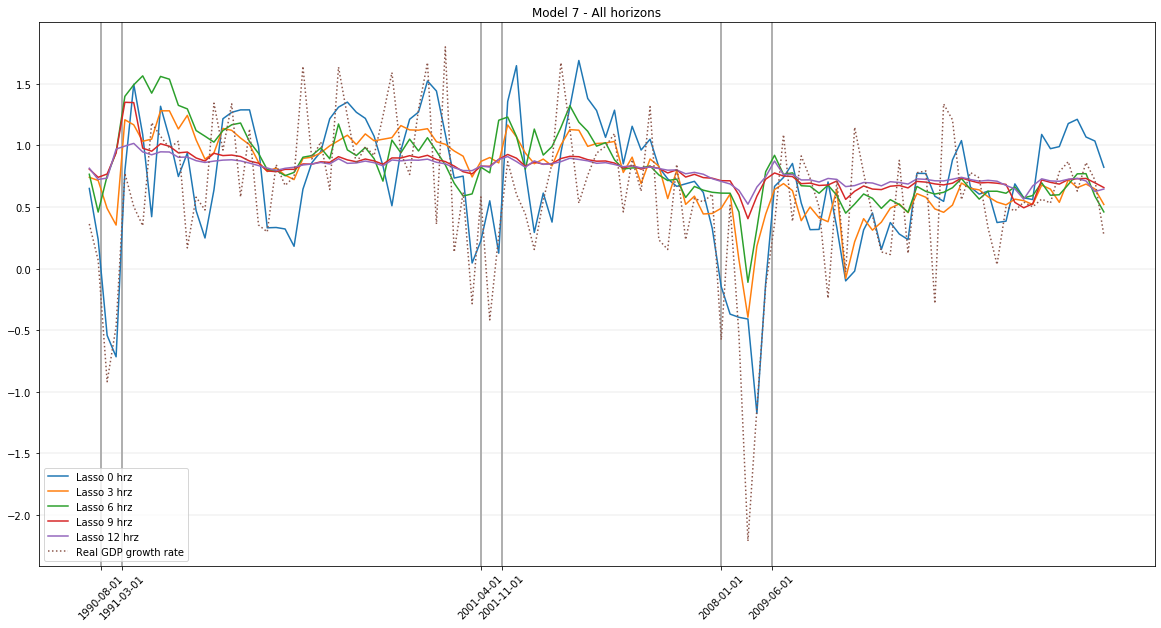

In [271]:
recession_dates = ['1990-08-01',
                '1991-03-01',
                '2001-04-01',
                '2001-11-01',
                '2008-01-01',
                '2009-06-01']
recession_dates_time = [datetime.strptime(x, '%Y-%m-%d') for x in recession_dates]


#Plotting
testdates = pd.date_range(start = "1990-02-01",
                          end = "2018-10-01",
                         freq = 'Q')

plt.figure(figsize=(20,10))
plt.plot(testdates, predicted_lst_0, label = 'Lasso 0 hrz')
plt.plot(testdates, predicted_lst_3, label = 'Lasso 3 hrz')
plt.plot(testdates, predicted_lst_6, label = 'Lasso 6 hrz')
plt.plot(testdates, predicted_lst_9, label = 'Lasso 9 hrz')
plt.plot(testdates, predicted_lst_12, label = 'Lasso 12 hrz')
plt.plot(testdates, yTest_q0, label = 'Real GDP growth rate', linestyle = ':')



plt.xticks(ticks = recession_dates_time, labels = recession_dates, rotation = 45)



plt.title('Model 7 - All horizons')
plt.grid(linewidth = 2, axis = 'x')
plt.grid(linestyle = '-', linewidth = 0.25, axis = 'y')
plt.legend()
plt.savefig('Model 7 - All horizons.png')
plt.show()

Despite the better RMSE and other error measures the predictions for 12 months in advance are not as accurate. In fact as you can see from the graph it's basically flat and has almost no predictive power. In this case it seems the Lasso approach is better at detecting the growth at very short horizons

# Model 8 - Ridge Regression with chained and tscv

In [225]:
#Before doing Ridge I extracted the grid of alphas parameters I employed in the lasso

model_q_chain_tscv.fit(x_q, y_q['GDPC1'])
grid_alphas = model_q_chain_tscv.alphas_


#I need the index to be a datetiqe object
df_q.index = pd.to_datetime(df_q.index)

y_q_L2_chain_tscv = df_q[q_hrz_lst]
y_q_L2_chain_tscv = y_q.dropna()
x_q_L2_chain_tscv = df_q.drop(columns = q_hrz_lst)
x_q_L2_chain_tscv = x_q_L2_chain_tscv[:y_q_L2_chain_tscv.shape[0]]

n_splits = len(x_q_L2_chain_tscv)-2
#Number of train/cv/test folds

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_q_L2_chain_tscv)
for i in range(28*4):
    next(trainTestSplit)#Skip the first fold

rqse_q_L2_chain_tscv = []
loss_q_L2_chain_tscv = []
predicted_q_L2_chain_tscv = np.array([])
pred_proba_q_L2_chain_tscv = np.array([])

for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_q_L2_chain_tscv.iloc[trainCvIndices,0:], y_q_L2_chain_tscv.iloc[trainCvIndices,0:]
    XTest, yTest       = x_q_L2_chain_tscv.iloc[testIndices,0:]   , y_q_L2_chain_tscv.iloc[testIndices,0:]
    
    # Then, we build a list of the forq [ ( [...Train Indices...], [...CV Indices...]  )]
    testLength = len(XTest)
    
    # Cross validation split
    tscv = TimeSeriesSplit(n_splits = 10).split(XTrainCv, y = yTrainCv)
    
    
    #model construction and wrapper
    model_q_L2_chain_tscv = RidgeCV(
            alphas = grid_alphas,
            cv = list(tscv),
            fit_intercept = True)
    wrapper = RegressorChain(model_q_L2_chain_tscv)
    wrapper.fit(XTrainCv, yTrainCv)
    
    #Probabilities and predictions
    ypredicted_q_L2_chain_tscv = wrapper.predict(XTest)
    predicted_q_L2_chain_tscv = np.append(predicted_q_L2_chain_tscv, ypredicted_q_L2_chain_tscv)

    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())

Training: 1962-01-01 -- 1989-10-01 , Cv: 1990-01-01 -- 1990-01-01 , Test: 1990-04-01 -- 1990-04-01
Training: 1962-01-01 -- 1990-01-01 , Cv: 1990-04-01 -- 1990-04-01 , Test: 1990-07-01 -- 1990-07-01
Training: 1962-01-01 -- 1990-04-01 , Cv: 1990-07-01 -- 1990-07-01 , Test: 1990-10-01 -- 1990-10-01
Training: 1962-01-01 -- 1990-07-01 , Cv: 1990-10-01 -- 1990-10-01 , Test: 1991-01-01 -- 1991-01-01
Training: 1962-01-01 -- 1990-10-01 , Cv: 1991-01-01 -- 1991-01-01 , Test: 1991-04-01 -- 1991-04-01
Training: 1962-01-01 -- 1991-01-01 , Cv: 1991-04-01 -- 1991-04-01 , Test: 1991-07-01 -- 1991-07-01
Training: 1962-01-01 -- 1991-04-01 , Cv: 1991-07-01 -- 1991-07-01 , Test: 1991-10-01 -- 1991-10-01
Training: 1962-01-01 -- 1991-07-01 , Cv: 1991-10-01 -- 1991-10-01 , Test: 1992-01-01 -- 1992-01-01
Training: 1962-01-01 -- 1991-10-01 , Cv: 1992-01-01 -- 1992-01-01 , Test: 1992-04-01 -- 1992-04-01
Training: 1962-01-01 -- 1992-01-01 , Cv: 1992-04-01 -- 1992-04-01 , Test: 1992-07-01 -- 1992-07-01
Training: 

Training: 1962-01-01 -- 2010-07-01 , Cv: 2010-10-01 -- 2010-10-01 , Test: 2011-01-01 -- 2011-01-01
Training: 1962-01-01 -- 2010-10-01 , Cv: 2011-01-01 -- 2011-01-01 , Test: 2011-04-01 -- 2011-04-01
Training: 1962-01-01 -- 2011-01-01 , Cv: 2011-04-01 -- 2011-04-01 , Test: 2011-07-01 -- 2011-07-01
Training: 1962-01-01 -- 2011-04-01 , Cv: 2011-07-01 -- 2011-07-01 , Test: 2011-10-01 -- 2011-10-01
Training: 1962-01-01 -- 2011-07-01 , Cv: 2011-10-01 -- 2011-10-01 , Test: 2012-01-01 -- 2012-01-01
Training: 1962-01-01 -- 2011-10-01 , Cv: 2012-01-01 -- 2012-01-01 , Test: 2012-04-01 -- 2012-04-01
Training: 1962-01-01 -- 2012-01-01 , Cv: 2012-04-01 -- 2012-04-01 , Test: 2012-07-01 -- 2012-07-01
Training: 1962-01-01 -- 2012-04-01 , Cv: 2012-07-01 -- 2012-07-01 , Test: 2012-10-01 -- 2012-10-01
Training: 1962-01-01 -- 2012-07-01 , Cv: 2012-10-01 -- 2012-10-01 , Test: 2013-01-01 -- 2013-01-01
Training: 1962-01-01 -- 2012-10-01 , Cv: 2013-01-01 -- 2013-01-01 , Test: 2013-04-01 -- 2013-04-01
Training: 

In [226]:
# Uncomment below when needed
predicted_q_L2_chain_tscv = predicted_q_L2_chain_tscv.tolist()

predicted_lst_0 = predicted_q_L2_chain_tscv[0::5]
yTest_q0 = df_q['GDPC1']['1990-04-01':'2018-10-01']
errors_0 = regression_results(yTest_q0, predicted_lst_0)

predicted_lst_3 = predicted_q_L2_chain_tscv[1::5]
yTest_q3 = df_q['GDPC1+1']['1990-02-01':'2018-12-01']
errors_3 = regression_results(yTest_q3, predicted_lst_3)

predicted_lst_6 = predicted_q_L2_chain_tscv[2::5]
yTest_q6 = df_q['GDPC1+2']['1990-02-01':'2018-12-01']
errors_6 = regression_results(yTest_q6, predicted_lst_6)

predicted_lst_9 = predicted_q_L2_chain_tscv[3::5]
yTest_q9 = df_q['GDPC1+3']['1990-02-01':'2018-12-01']
errors_9 = regression_results(yTest_q9, predicted_lst_9)


predicted_lst_12 = predicted_q_L2_chain_tscv[4::5]
yTest_q12 = df_q['GDPC1+4']['1990-02-01':'2018-12-01']
errors_12 = regression_results(yTest_q12, predicted_lst_12)



errors_tscv_L2_chain = pd.DataFrame(data = [errors_0,
                                        errors_3,
                                        errors_6,
                                        errors_9,
                                        errors_12],
                                 index = ['lag_0',
                                         'lag_3',
                                         'lag_6',
                                         'lag_9',
                                         'lag_12'],
                                columns = ['MAE', 'MSE', 'RMSE', 'R^2'])

errors_tscv_L2_chain

,MAE,MSE,RMSE,R^2
lag_0,0.443285,0.321588,0.567087,0.065222
lag_3,0.458613,0.331343,0.575624,0.036022
lag_6,0.475667,0.398617,0.631361,-0.167990
lag_9,0.467115,0.385249,0.620684,-0.200562
lag_12,0.454610,0.386371,0.621588,-0.244240


# Coefficents

In [211]:
model_q_chain_tscv.fit(x_q, y_q['GDPC1'])
# list(model_q_chain_tscv.coef_)
# list(x_q.columns)

coeff_df = pd.DataFrame(model_q_chain_tscv.coef_ , index = x_q.columns, columns = ['Coefficient'])
coeff_df.transpose()
coeff_df

,Coefficient
GDPC1_lag1,-0.069525
GDPC1_lag2,0.000000
GS10,0.000000
TB3MS,0.000000
GS1,0.000000
AAA10YM,-0.250057
DTB6,0.000000
BAA10YM,-0.000000
FEDFUNDS,0.000000
WPU102301,-0.000000


In [77]:
model_q_chain_tscv.fit(x_q[:'2018-10-01'], y_q['GDPC1+4'][:'2018-10-01'])
model_q_chain_tscv.coef_

array([-0.        ,  0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.19119223,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.25528252, -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.38791542,  0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.04259493, -0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        , -0.        ,
        0.        ,  0.0197293 , -0.        , -0.        , -0.        ])

# Bechmarks
## Em model chained

In [133]:
#I need the index to be a datetiqe object
df_q.index = pd.to_datetime(df_q.index)

y_q_chain_em_tscv = df_q[q_hrz_lst]
y_q_chain_em_tscv = y_q.dropna()
x_q_chain_em_tscv = df_q[['10Y-3M','R_S&P500']]
x_q_chain_em_tscv = x_q_chain_em_tscv[:y_q_chain_em_tscv.shape[0]]

n_splits = len(x_q_chain_em_tscv)-2
#Nuqber of train/cv/test folds
#58 or 57 is the nuqber for annual splits qore or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_q_chain_em_tscv)
for i in range(28*4):
    next(trainTestSplit)#Skip the first fold

rqse_q_chain_em_tscv = []
loss_q_chain_em_tscv = []
predicted_q_chain_em_tscv = np.array([])
pred_proba_q_chain_em_tscv = np.array([])

for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_q_chain_em_tscv.iloc[trainCvIndices,0:], y_q_chain_em_tscv.iloc[trainCvIndices,0:]
    XTest, yTest       = x_q_chain_em_tscv.iloc[testIndices,0:]   , y_q_chain_em_tscv.iloc[testIndices,0:]
    
    # Then, we build a list of the form [ ( [...Train Indices...], [...CV Indices...]  )]
    testLength = len(XTest)
    
    #model construction and wrapper
    model_q_chain_em_tscv = LinearRegression(n_jobs = -1, fit_intercept = True)
    wrapper = RegressorChain(model_q_chain_em_tscv)
    wrapper.fit(XTrainCv, yTrainCv)
    
    #Probabilities and predictions
    ypredicted_q_chain_em_tscv = wrapper.predict(XTest)
    predicted_q_chain_em_tscv = np.append(predicted_q_chain_em_tscv, ypredicted_q_chain_em_tscv)

    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())

Training: 1962-01-01 -- 1989-10-01 , Cv: 1990-01-01 -- 1990-01-01 , Test: 1990-04-01 -- 1990-04-01
Training: 1962-01-01 -- 1990-01-01 , Cv: 1990-04-01 -- 1990-04-01 , Test: 1990-07-01 -- 1990-07-01
Training: 1962-01-01 -- 1990-04-01 , Cv: 1990-07-01 -- 1990-07-01 , Test: 1990-10-01 -- 1990-10-01
Training: 1962-01-01 -- 1990-07-01 , Cv: 1990-10-01 -- 1990-10-01 , Test: 1991-01-01 -- 1991-01-01
Training: 1962-01-01 -- 1990-10-01 , Cv: 1991-01-01 -- 1991-01-01 , Test: 1991-04-01 -- 1991-04-01
Training: 1962-01-01 -- 1991-01-01 , Cv: 1991-04-01 -- 1991-04-01 , Test: 1991-07-01 -- 1991-07-01
Training: 1962-01-01 -- 1991-04-01 , Cv: 1991-07-01 -- 1991-07-01 , Test: 1991-10-01 -- 1991-10-01
Training: 1962-01-01 -- 1991-07-01 , Cv: 1991-10-01 -- 1991-10-01 , Test: 1992-01-01 -- 1992-01-01
Training: 1962-01-01 -- 1991-10-01 , Cv: 1992-01-01 -- 1992-01-01 , Test: 1992-04-01 -- 1992-04-01
Training: 1962-01-01 -- 1992-01-01 , Cv: 1992-04-01 -- 1992-04-01 , Test: 1992-07-01 -- 1992-07-01
Training: 

Training: 1962-01-01 -- 2012-04-01 , Cv: 2012-07-01 -- 2012-07-01 , Test: 2012-10-01 -- 2012-10-01
Training: 1962-01-01 -- 2012-07-01 , Cv: 2012-10-01 -- 2012-10-01 , Test: 2013-01-01 -- 2013-01-01
Training: 1962-01-01 -- 2012-10-01 , Cv: 2013-01-01 -- 2013-01-01 , Test: 2013-04-01 -- 2013-04-01
Training: 1962-01-01 -- 2013-01-01 , Cv: 2013-04-01 -- 2013-04-01 , Test: 2013-07-01 -- 2013-07-01
Training: 1962-01-01 -- 2013-04-01 , Cv: 2013-07-01 -- 2013-07-01 , Test: 2013-10-01 -- 2013-10-01
Training: 1962-01-01 -- 2013-07-01 , Cv: 2013-10-01 -- 2013-10-01 , Test: 2014-01-01 -- 2014-01-01
Training: 1962-01-01 -- 2013-10-01 , Cv: 2014-01-01 -- 2014-01-01 , Test: 2014-04-01 -- 2014-04-01
Training: 1962-01-01 -- 2014-01-01 , Cv: 2014-04-01 -- 2014-04-01 , Test: 2014-07-01 -- 2014-07-01
Training: 1962-01-01 -- 2014-04-01 , Cv: 2014-07-01 -- 2014-07-01 , Test: 2014-10-01 -- 2014-10-01
Training: 1962-01-01 -- 2014-07-01 , Cv: 2014-10-01 -- 2014-10-01 , Test: 2015-01-01 -- 2015-01-01
Training: 

In [256]:
#Uncomment below when needed
# predicted_q_chain_em_tscv = predicted_q_chain_em_tscv.tolist()

predicted_lst_0 = predicted_q_chain_em_tscv[0::5]
yTest_q0 = df_q['GDPC1']['1990-04-01':'2018-10-01']
errors_0 = regression_results(yTest_q0, predicted_lst_0)

predicted_lst_3 = predicted_q_chain_em_tscv[1::5]
yTest_q3 = df_q['GDPC1+1']['1990-02-01':'2018-12-01']
errors_3 = regression_results(yTest_q3, predicted_lst_3)

predicted_lst_6 = predicted_q_chain_em_tscv[2::5]
yTest_q6 = df_q['GDPC1+2']['1990-02-01':'2018-12-01']
errors_6 = regression_results(yTest_q6, predicted_lst_6)

predicted_lst_9 = predicted_q_chain_em_tscv[3::5]
yTest_q9 = df_q['GDPC1+3']['1990-02-01':'2018-12-01']
errors_9 = regression_results(yTest_q9, predicted_lst_9)


predicted_lst_12 = predicted_q_chain_em_tscv[4::5]
yTest_q12 = df_q['GDPC1+4']['1990-02-01':'2018-12-01']
errors_12 = regression_results(yTest_q12, predicted_lst_12)



errors_em_tscv_chain = pd.DataFrame(data = [errors_0,
                                        errors_3,
                                        errors_6,
                                        errors_9,
                                        errors_12],
                                 index = ['lag_0',
                                         'lag_3',
                                         'lag_6',
                                         'lag_9',
                                         'lag_12'],
                                columns = ['MAE', 'MSE', 'RMSE', 'R^2'])

errors_em_tscv_chain

,MAE,MSE,RMSE,R^2
lag_0,0.510022,0.491769,0.701263,-0.429454
lag_3,0.523580,0.521184,0.721931,-0.516282
lag_6,0.510275,0.508273,0.712933,-0.489295
lag_9,0.460901,0.404167,0.635741,-0.259516
lag_12,0.438066,0.354638,0.595515,-0.142048


In [195]:
errors_tscv_chain

,MAE,MSE,RMSE,R^2
lag_0,0.386625,0.251968,0.501964,0.267591
lag_3,0.411825,0.314128,0.560471,0.086107
lag_6,0.427750,0.359723,0.599769,-0.054026
lag_9,0.391515,0.327609,0.572371,-0.020936
lag_12,0.389015,0.318861,0.564678,-0.026835


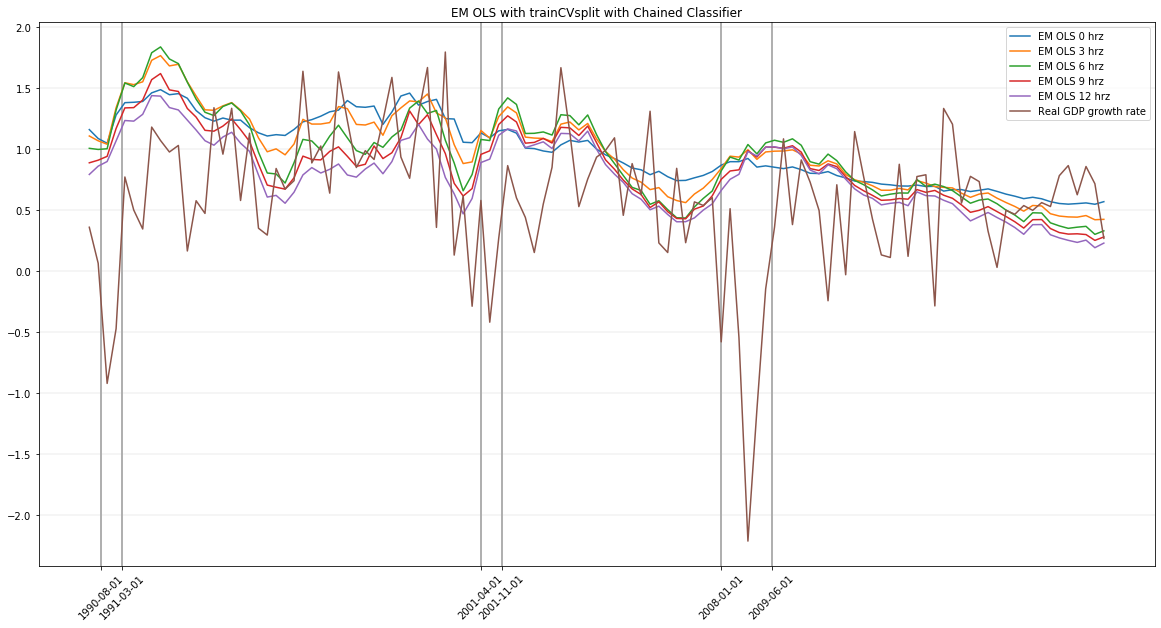

In [138]:
#Plotting
testdates = pd.date_range(start = "1990-02-01",
                          end = "2018-10-01",
                         freq = 'Q')

plt.figure(figsize=(20,10))
plt.plot(testdates, predicted_lst_0, label = 'EM OLS 0 hrz')
plt.plot(testdates, predicted_lst_3, label = 'EM OLS 3 hrz')
plt.plot(testdates, predicted_lst_6, label = 'EM OLS 6 hrz')
plt.plot(testdates, predicted_lst_9, label = 'EM OLS 9 hrz')
plt.plot(testdates, predicted_lst_12, label = 'EM OLS 12 hrz')
plt.plot(testdates, yTest_q0, label = 'Real GDP growth rate')



plt.xticks(ticks = recession_dates_time, labels = recession_dates, rotation = 45)



plt.title('EM OLS with trainCVsplit with Chained Classifier')
plt.grid(linewidth = 2, axis = 'x')
plt.grid(linestyle = '-', linewidth = 0.25, axis = 'y')
plt.legend()
plt.show()

Still EM proves to be worse in terms of pure error metrics but at least the later horizons are not as flat as for the Lasso model

## EM multioutput

In [139]:
#I need the index to be a datetiqe object
df_q.index = pd.to_datetime(df_q.index)

y_q_all_em_tscv = df_q[q_hrz_lst]
y_q_all_em_tscv = y_q.dropna()
x_q_all_em_tscv = df_q[['10Y-3M','R_S&P500']]
x_q_all_em_tscv = x_q_all_em_tscv[:y_q_all_em_tscv.shape[0]]

n_splits = len(x_q_all_em_tscv)-2
#Nuqber of train/cv/test folds
#58 or 57 is the nuqber for annual splits qore or less

trainTestSplit = TimeSeriesSplit(n_splits+1).split(x_q_all_em_tscv)
for i in range(28*4):
    next(trainTestSplit)#Skip the first fold

rqse_q_all_em_tscv = []
loss_q_all_em_tscv = []
predicted_q_all_em_tscv = np.array([])
pred_proba_q_all_em_tscv = np.array([])

for trainCvIndices, testIndices in trainTestSplit:
    # First, we split Train + CV and Test
    XTrainCv, yTrainCv = x_q_all_em_tscv.iloc[trainCvIndices,0:], y_q_all_em_tscv.iloc[trainCvIndices,0:]
    XTest, yTest       = x_q_all_em_tscv.iloc[testIndices,0:]   , y_q_all_em_tscv.iloc[testIndices,0:]
    
    # Then, we build a list of the form [ ( [...Train Indices...], [...CV Indices...]  )]
    testLength = len(XTest)
    
    #model construction and wrapper
    model_q_all_em_tscv = LinearRegression(n_jobs = -1, fit_intercept = True)
    wrapper = MultiOutputRegressor(model_q_all_em_tscv)
    wrapper.fit(XTrainCv, yTrainCv)
    
    #Probabilities and predictions
    ypredicted_q_all_em_tscv = wrapper.predict(XTest)
    predicted_q_all_em_tscv = np.append(predicted_q_all_em_tscv, ypredicted_q_all_em_tscv)

    # Printing date ranges
    print("Training:"           , XTrainCv.index[0].date(), "--", XTrainCv.index[-testLength-1].date(),
          ", Cv:"     , XTrainCv.index[-testLength].date(), "--", XTrainCv.index[-1].date(),
          ", Test:"                , XTest.index[0].date(), "--", XTest.index[-1].date())

Training: 1962-01-01 -- 1989-10-01 , Cv: 1990-01-01 -- 1990-01-01 , Test: 1990-04-01 -- 1990-04-01
Training: 1962-01-01 -- 1990-01-01 , Cv: 1990-04-01 -- 1990-04-01 , Test: 1990-07-01 -- 1990-07-01
Training: 1962-01-01 -- 1990-04-01 , Cv: 1990-07-01 -- 1990-07-01 , Test: 1990-10-01 -- 1990-10-01
Training: 1962-01-01 -- 1990-07-01 , Cv: 1990-10-01 -- 1990-10-01 , Test: 1991-01-01 -- 1991-01-01
Training: 1962-01-01 -- 1990-10-01 , Cv: 1991-01-01 -- 1991-01-01 , Test: 1991-04-01 -- 1991-04-01
Training: 1962-01-01 -- 1991-01-01 , Cv: 1991-04-01 -- 1991-04-01 , Test: 1991-07-01 -- 1991-07-01
Training: 1962-01-01 -- 1991-04-01 , Cv: 1991-07-01 -- 1991-07-01 , Test: 1991-10-01 -- 1991-10-01
Training: 1962-01-01 -- 1991-07-01 , Cv: 1991-10-01 -- 1991-10-01 , Test: 1992-01-01 -- 1992-01-01
Training: 1962-01-01 -- 1991-10-01 , Cv: 1992-01-01 -- 1992-01-01 , Test: 1992-04-01 -- 1992-04-01
Training: 1962-01-01 -- 1992-01-01 , Cv: 1992-04-01 -- 1992-04-01 , Test: 1992-07-01 -- 1992-07-01
Training: 

Training: 1962-01-01 -- 2016-07-01 , Cv: 2016-10-01 -- 2016-10-01 , Test: 2017-01-01 -- 2017-01-01
Training: 1962-01-01 -- 2016-10-01 , Cv: 2017-01-01 -- 2017-01-01 , Test: 2017-04-01 -- 2017-04-01
Training: 1962-01-01 -- 2017-01-01 , Cv: 2017-04-01 -- 2017-04-01 , Test: 2017-07-01 -- 2017-07-01
Training: 1962-01-01 -- 2017-04-01 , Cv: 2017-07-01 -- 2017-07-01 , Test: 2017-10-01 -- 2017-10-01
Training: 1962-01-01 -- 2017-07-01 , Cv: 2017-10-01 -- 2017-10-01 , Test: 2018-01-01 -- 2018-01-01
Training: 1962-01-01 -- 2017-10-01 , Cv: 2018-01-01 -- 2018-01-01 , Test: 2018-04-01 -- 2018-04-01
Training: 1962-01-01 -- 2018-01-01 , Cv: 2018-04-01 -- 2018-04-01 , Test: 2018-07-01 -- 2018-07-01
Training: 1962-01-01 -- 2018-04-01 , Cv: 2018-07-01 -- 2018-07-01 , Test: 2018-10-01 -- 2018-10-01


In [257]:
#Uncomment below when needed
# predicted_q_all_em_tscv = predicted_q_all_em_tscv.tolist()

predicted_lst_0 = predicted_q_all_em_tscv[0::5]
yTest_q0 = df_q['GDPC1']['1990-04-01':'2018-10-01']
errors_0 = regression_results(yTest_q0, predicted_lst_0)

predicted_lst_3 = predicted_q_all_em_tscv[1::5]
yTest_q3 = df_q['GDPC1+1']['1990-02-01':'2018-12-01']
errors_3 = regression_results(yTest_q3, predicted_lst_3)

predicted_lst_6 = predicted_q_all_em_tscv[2::5]
yTest_q6 = df_q['GDPC1+2']['1990-02-01':'2018-12-01']
errors_6 = regression_results(yTest_q6, predicted_lst_6)

predicted_lst_9 = predicted_q_all_em_tscv[3::5]
yTest_q9 = df_q['GDPC1+3']['1990-02-01':'2018-12-01']
errors_9 = regression_results(yTest_q9, predicted_lst_9)


predicted_lst_12 = predicted_q_all_em_tscv[4::5]
yTest_q12 = df_q['GDPC1+4']['1990-02-01':'2018-12-01']
errors_12 = regression_results(yTest_q12, predicted_lst_12)



errors_em_tscv_all = pd.DataFrame(data = [errors_0,
                                        errors_3,
                                        errors_6,
                                        errors_9,
                                        errors_12],
                                 index = ['lag_0',
                                         'lag_3',
                                         'lag_6',
                                         'lag_9',
                                         'lag_12'],
                                columns = ['MAE', 'MSE', 'RMSE', 'R^2'])

errors_em_tscv_all

,MAE,MSE,RMSE,R^2
lag_0,0.510022,0.491769,0.701263,-0.429454
lag_3,0.523580,0.521184,0.721931,-0.516282
lag_6,0.510275,0.508273,0.712933,-0.489295
lag_9,0.460901,0.404167,0.635741,-0.259516
lag_12,0.438066,0.354638,0.595515,-0.142048


In [258]:
errors_em_tscv_chain

,MAE,MSE,RMSE,R^2
lag_0,0.510022,0.491769,0.701263,-0.429454
lag_3,0.523580,0.521184,0.721931,-0.516282
lag_6,0.510275,0.508273,0.712933,-0.489295
lag_9,0.460901,0.404167,0.635741,-0.259516
lag_12,0.438066,0.354638,0.595515,-0.142048


Exactly the same results as with the chained version

# Survery of Professional Forecasters

In [144]:
df_spf

,YEAR,QUARTER,NGDP1,NGDP2,NGDP3,NGDP4,NGDP5,NGDP6,NGDPA,NGDPB,Unnamed: 10,Unnamed: 11
1968-12-31,1968,4,870.93,884.78,896.54,908.77,923.77,939.79,NaN,NaN,NaN,NaN
1969-03-31,1969,1,887.84,900.67,912.05,926.00,940.98,NaN,NaN,NaN,NaN,1 is quarter before
1969-06-30,1969,2,903.02,916.88,930.00,941.68,954.18,NaN,NaN,NaN,NaN,2 is current quarter
1969-09-30,1969,3,924.93,938.73,950.68,961.63,973.86,NaN,NaN,NaN,NaN,3 is next quarter and so on
1969-12-31,1969,4,942.86,954.26,963.79,973.26,987.89,"1,004.60",NaN,NaN,NaN,A is current yer
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30,2019,2,"21,062.70","21,276.98","21,499.56","21,723.42","21,937.65","22,159.90","21,391.45","22,254.96",NaN,NaN
2019-09-30,2019,3,"21,337.90","21,538.67","21,754.36","21,964.99","22,175.29","22,388.01","21,432.86","22,277.63",NaN,NaN
2019-12-31,2019,4,"21,525.80","21,721.77","21,924.05","22,145.50","22,352.62","22,565.83","21,422.28","22,248.00",NaN,NaN
2020-03-31,2020,1,"21,734.30","21,924.78","22,147.09","22,370.61","22,600.61","22,828.48","22,261.47","23,166.72",NaN,NaN


In [183]:
df_spf = pd.read_csv('Mean_NGDP_Level.csv')
df_spf.index = pd.date_range(start = "1968-10-01",
                          end = "2020-07-01",
                         freq = 'Q')
df_spf = df_spf.drop(columns = ['YEAR', 'QUARTER', 'Unnamed: 10', 'Unnamed: 11', 'NGDPA', 'NGDPB'])
df_spf = df_spf['1990-04-01':'2019-01-01']
# df_spf = df_spf/100
df_spf

,NGDP1,NGDP2,NGDP3,NGDP4,NGDP5,NGDP6
1990-06-30,"5,433.02","5,519.09","5,601.30","5,682.57","5,765.46","5,846.43"
1990-09-30,"5,452.88","5,524.88","5,594.71","5,668.73","5,741.23","5,829.48"
1990-12-31,"5,511.53","5,561.66","5,615.25","5,672.40","5,750.01","5,836.25"
1991-03-31,"5,519.00","5,555.14","5,606.60","5,680.13","5,765.02","5,853.46"
1991-06-30,"5,561.64","5,605.75","5,683.56","5,769.77","5,863.92","5,951.42"
...,...,...,...,...,...,...
2017-12-31,"19,495.55","19,711.22","19,923.54","20,141.05","20,359.46","20,575.86"
2018-03-31,"19,738.93","19,975.55","20,213.07","20,456.06","20,692.61","20,931.35"
2018-06-30,"19,965.23","20,217.90","20,472.60","20,720.90","20,969.87","21,217.05"
2018-09-30,"20,402.50","20,655.34","20,916.96","21,167.38","21,421.69","21,665.99"


In [262]:
#Creating the growth rate
NGDP_growth_0 = []
NGDP_growth_3 = []
NGDP_growth_6 = []
NGDP_growth_9 = []
NGDP_growth_12 = []

for index, row in df_spf.iterrows():
    NGDP_growth_0.append(float(row['NGDP2'].replace(',',''))*100/float(row['NGDP1'].replace(',','')) - 100)
    NGDP_growth_3.append(float(row['NGDP3'].replace(',',''))*100/float(row['NGDP2'].replace(',','')) - 100)
    NGDP_growth_6.append(float(row['NGDP4'].replace(',',''))*100/float(row['NGDP3'].replace(',','')) - 100)
    NGDP_growth_9.append(float(row['NGDP5'].replace(',',''))*100/float(row['NGDP4'].replace(',','')) - 100)
    NGDP_growth_12.append(float(row['NGDP6'].replace(',',''))*100/float(row['NGDP5'].replace(',','')) - 100)

In [263]:
errors_0 = regression_results(yTest_q0, NGDP_growth_0)
errors_3 = regression_results(yTest_q3, NGDP_growth_3)
errors_6 = regression_results(yTest_q6, NGDP_growth_6)
errors_9 = regression_results(yTest_q9, NGDP_growth_9)
errors_12 = regression_results(yTest_q12, NGDP_growth_12)

errors_spf = pd.DataFrame(data = [errors_0,
                                        errors_3,
                                        errors_6,
                                        errors_9,
                                        errors_12],
                                 index = ['lag_0',
                                         'lag_3',
                                         'lag_6',
                                         'lag_9',
                                         'lag_12'],
                                columns = ['MAE', 'MSE', 'RMSE', 'R^2'])

errors_spf

,MAE,MSE,RMSE,R^2
lag_0,0.558409,0.485463,0.696752,-0.411124
lag_3,0.626697,0.624711,0.790387,-0.817474
lag_6,0.666248,0.699514,0.836369,-1.049649
lag_9,0.678905,0.708930,0.841980,-1.209259
lag_12,0.681429,0.709566,0.842357,-1.285029


In [264]:
errors_tscv_chain

,MAE,MSE,RMSE,R^2
lag_0,0.386625,0.251968,0.501964,0.267591
lag_3,0.411825,0.314128,0.560471,0.086107
lag_6,0.427750,0.359723,0.599769,-0.054026
lag_9,0.391515,0.327609,0.572371,-0.020936
lag_12,0.389015,0.318861,0.564678,-0.026835


Arguably spf is worse across the board than the survey of professional forecasters and the graph below seems to suggest that too. Still the quarter results are not comparable to the monthly ones. The Accuracy is still very low and arguable only works at lag 0 and margianlly at lag 3

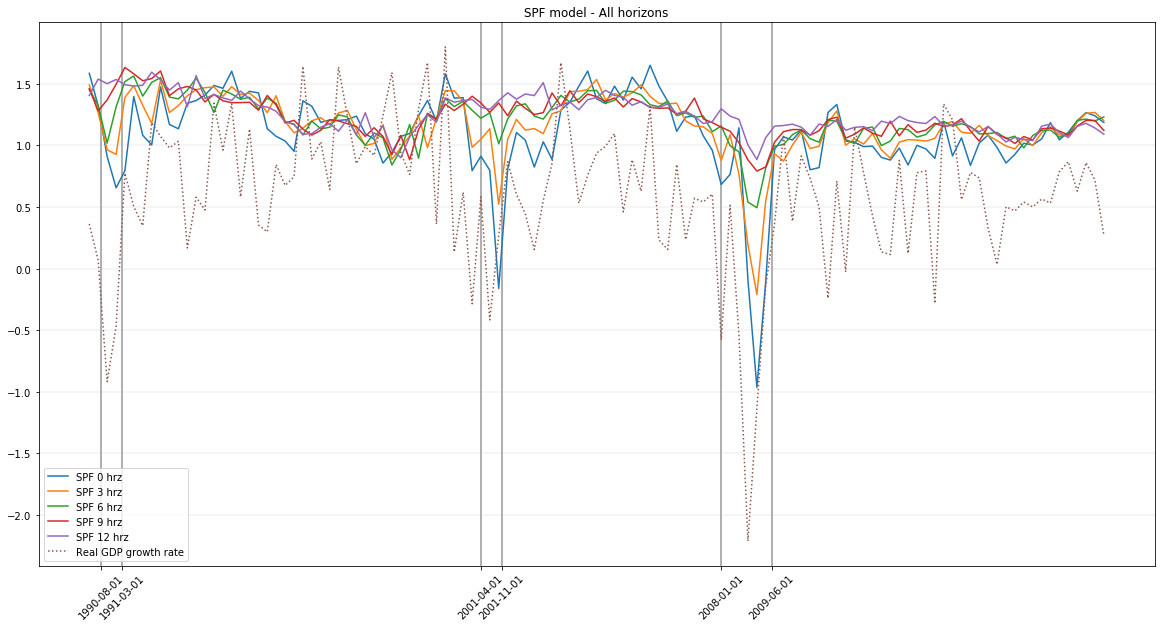

In [266]:
testdates = pd.date_range(start = "1990-02-01",
                          end = "2018-10-01",
                         freq = 'Q')

plt.figure(figsize=(20,10))
plt.plot(testdates, NGDP_growth_0, label = 'SPF 0 hrz')
plt.plot(testdates, NGDP_growth_3, label = 'SPF 3 hrz')
plt.plot(testdates, NGDP_growth_6, label = 'SPF 6 hrz')
plt.plot(testdates, NGDP_growth_9, label = 'SPF 9 hrz')
plt.plot(testdates, NGDP_growth_12, label = 'SPF 12 hrz')
plt.plot(testdates, yTest_q0, label = 'Real GDP growth rate', linestyle = ':')



plt.xticks(ticks = recession_dates_time, labels = recession_dates, rotation = 45)



plt.title('SPF model - All horizons')
plt.grid(linewidth = 2, axis = 'x')
plt.grid(linestyle = '-', linewidth = 0.25, axis = 'y')
plt.legend()
plt.savefig('SPF model - All horizons.png')
plt.show()